### Solving Poisson Equation on S^2: $\Delta u = f$


In [1]:
import my_ducc0_wrapper
from my_ducc0_wrapper import *

In [2]:
import torch

N = 200

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos
import numpy as np

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
# from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 100
problem = Problem_Sphere_Poisson()

In [3]:
N = 20
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([800, 2])

iteration 0: loss = 84.51212310791016


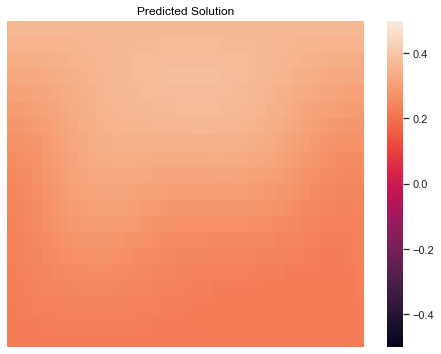

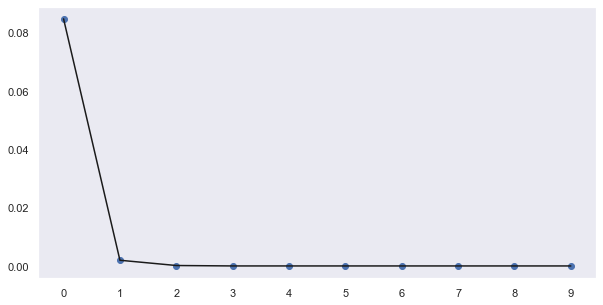

iteration 1: loss = 83.87693786621094
iteration 2: loss = 82.67060852050781
iteration 3: loss = 79.78990936279297
iteration 4: loss = 73.64605712890625
iteration 5: loss = 63.21717071533203
iteration 6: loss = 60.14680099487305
iteration 7: loss = 66.16017150878906
iteration 8: loss = 61.51848602294922
iteration 9: loss = 56.139400482177734
iteration 10: loss = 52.73173904418945


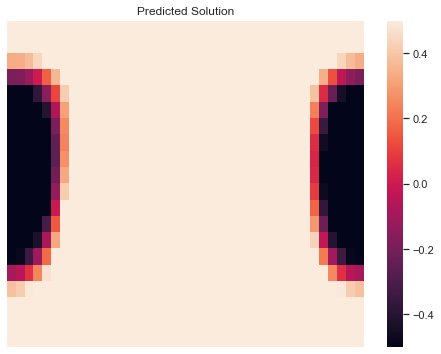

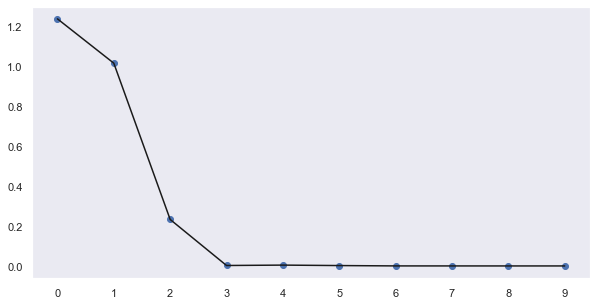

iteration 11: loss = 51.31755828857422
iteration 12: loss = 47.81681442260742
iteration 13: loss = 40.32598114013672
iteration 14: loss = 30.674240112304688
iteration 15: loss = 23.465988159179688
iteration 16: loss = 18.976991653442383
iteration 17: loss = 17.392854690551758
iteration 18: loss = 17.050098419189453
iteration 19: loss = 14.520320892333984
iteration 20: loss = 12.758977890014648


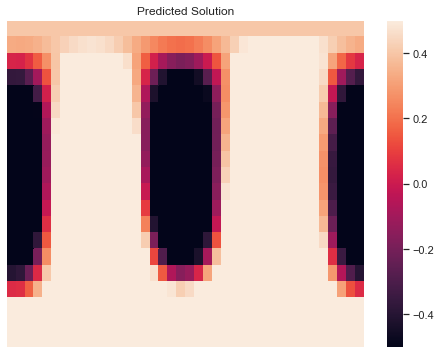

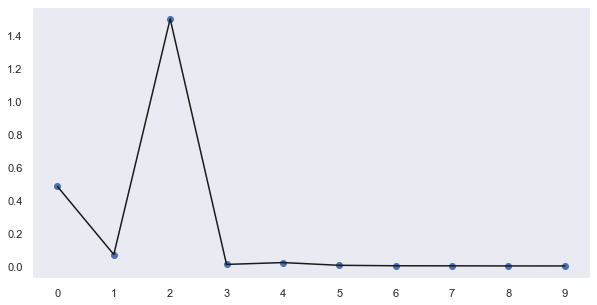

iteration 21: loss = 11.226644515991211
iteration 22: loss = 11.496052742004395
iteration 23: loss = 12.660311698913574
iteration 24: loss = 12.195931434631348
iteration 25: loss = 10.333123207092285
iteration 26: loss = 8.122231483459473
iteration 27: loss = 7.08024263381958
iteration 28: loss = 7.110437393188477
iteration 29: loss = 6.608697414398193
iteration 30: loss = 6.344873905181885


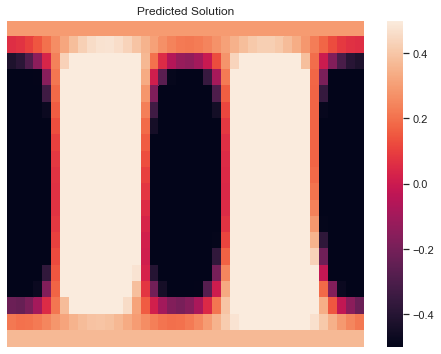

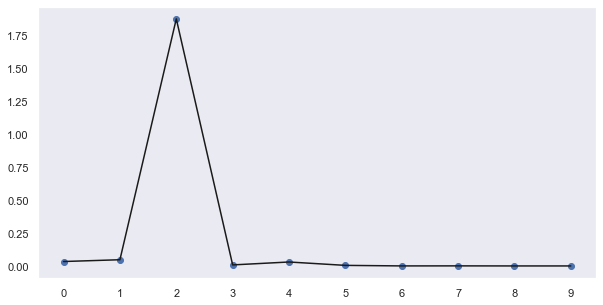

iteration 31: loss = 5.976719379425049
iteration 32: loss = 5.544498443603516
iteration 33: loss = 5.659748554229736
iteration 34: loss = 5.704302787780762
iteration 35: loss = 4.995518684387207
iteration 36: loss = 4.090856075286865
iteration 37: loss = 3.8580455780029297
iteration 38: loss = 4.251537322998047
iteration 39: loss = 4.477888107299805
iteration 40: loss = 4.225631237030029


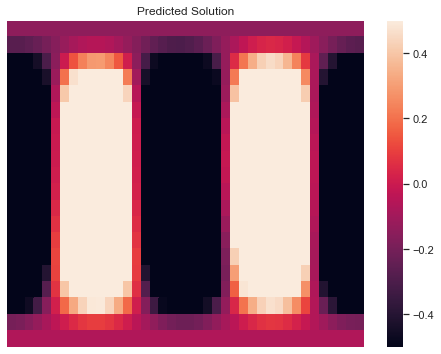

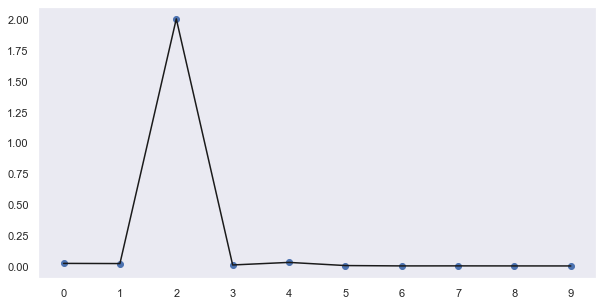

iteration 41: loss = 3.8112919330596924
iteration 42: loss = 3.5051891803741455
iteration 43: loss = 3.3564047813415527
iteration 44: loss = 3.1822242736816406
iteration 45: loss = 3.0214943885803223
iteration 46: loss = 3.009488821029663
iteration 47: loss = 3.1313328742980957
iteration 48: loss = 3.051168918609619
iteration 49: loss = 2.7483272552490234
iteration 50: loss = 2.6023945808410645


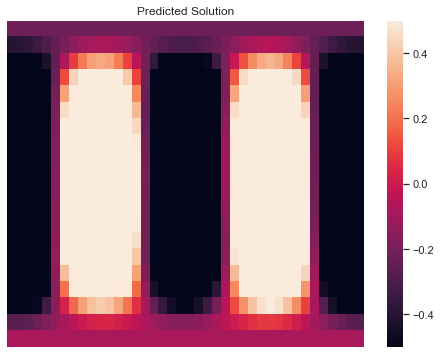

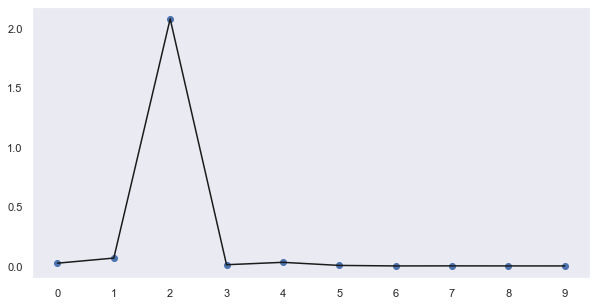

iteration 51: loss = 2.6709139347076416
iteration 52: loss = 2.647230863571167
iteration 53: loss = 2.4770939350128174
iteration 54: loss = 2.4087696075439453
iteration 55: loss = 2.4734137058258057
iteration 56: loss = 2.4381442070007324
iteration 57: loss = 2.2944893836975098
iteration 58: loss = 2.1951217651367188
iteration 59: loss = 2.1682169437408447
iteration 60: loss = 2.162414789199829


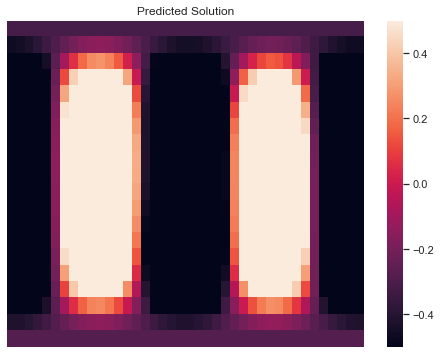

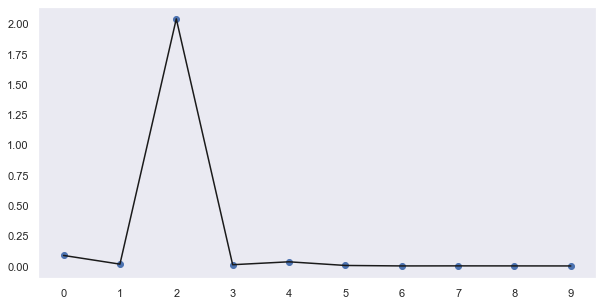

iteration 61: loss = 2.1553733348846436
iteration 62: loss = 2.125753879547119
iteration 63: loss = 2.063918352127075
iteration 64: loss = 1.995815396308899
iteration 65: loss = 1.9412513971328735
iteration 66: loss = 1.903642177581787
iteration 67: loss = 1.8748711347579956
iteration 68: loss = 1.8396683931350708
iteration 69: loss = 1.8017446994781494
iteration 70: loss = 1.7816529273986816


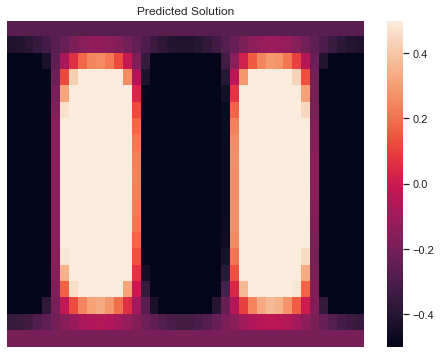

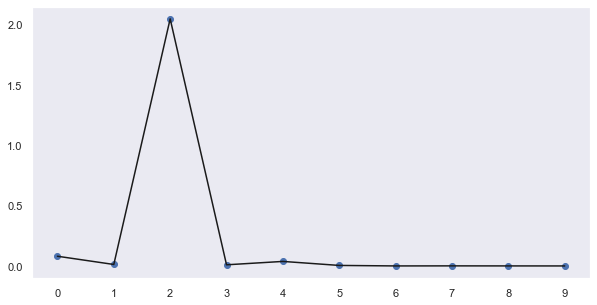

iteration 71: loss = 1.7534902095794678
iteration 72: loss = 1.700557827949524
iteration 73: loss = 1.658374547958374
iteration 74: loss = 1.6396746635437012
iteration 75: loss = 1.6073706150054932
iteration 76: loss = 1.5630093812942505
iteration 77: loss = 1.531684398651123
iteration 78: loss = 1.5083019733428955
iteration 79: loss = 1.4743434190750122
iteration 80: loss = 1.4409914016723633


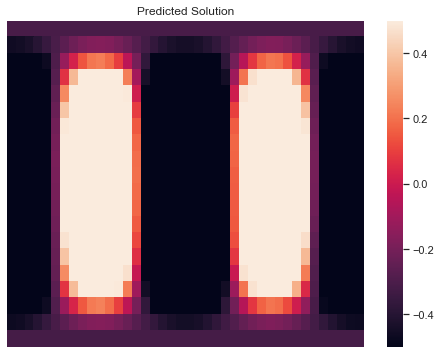

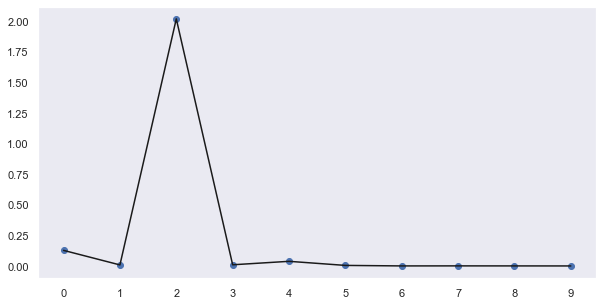

iteration 81: loss = 1.4179779291152954
iteration 82: loss = 1.392192006111145
iteration 83: loss = 1.3616300821304321
iteration 84: loss = 1.3349968194961548
iteration 85: loss = 1.3128446340560913
iteration 86: loss = 1.2884711027145386
iteration 87: loss = 1.268169641494751
iteration 88: loss = 1.2466673851013184
iteration 89: loss = 1.2203212976455688
iteration 90: loss = 1.1986041069030762


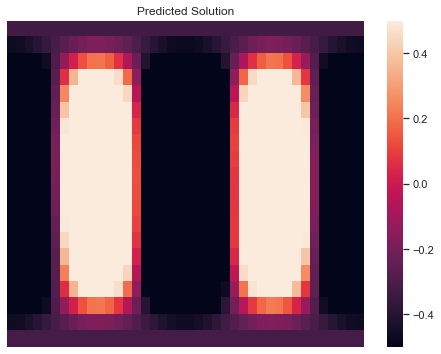

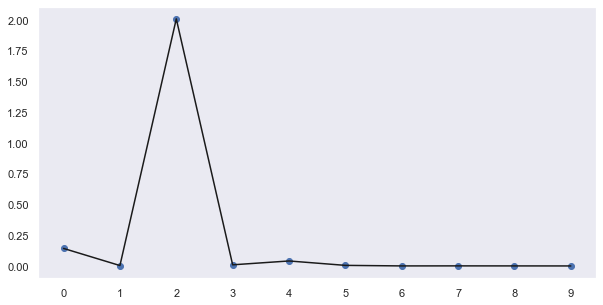

iteration 91: loss = 1.1781916618347168
iteration 92: loss = 1.1538091897964478
iteration 93: loss = 1.1360254287719727
iteration 94: loss = 1.1182008981704712
iteration 95: loss = 1.0942915678024292
iteration 96: loss = 1.07452392578125
iteration 97: loss = 1.056364893913269
iteration 98: loss = 1.0351414680480957
iteration 99: loss = 1.0165529251098633


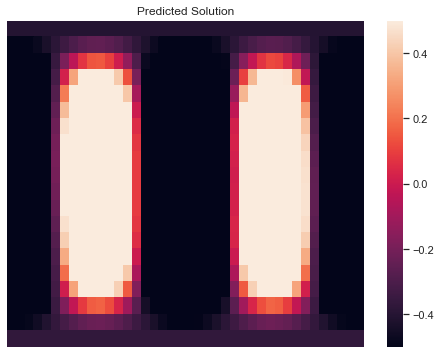

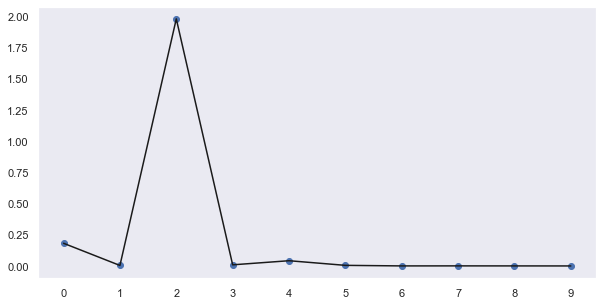

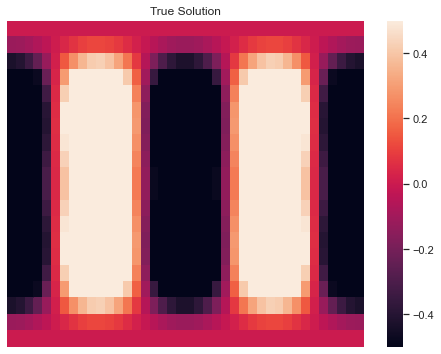

In [4]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=N):
#             N = 25
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            ## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

            azimuth, polar = torch.meshgrid(azimuth, polar)
#             print('azimuth', azimuth.size())
#             print('polar', polar.size())
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
#             print('location', location.size())
            return location
#             x = torch.randn(num, 3)
#             x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
        
#             polar = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
#             polar[:num // 2, 0] = polar[:num // 2, 0] + math.pi
#             azimuth = torch.acos(x[:, 2:3])
            
#             ## noise
#             dpolar = 2 * pi/(num-1) 
#             polar_noise = polar + torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
            
#             dazimuth = pi/(num-1) 
#             azimuth_noise = azimuth + torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(polar.shape))            
            
#             x = torch.cat([azimuth_noise, polar_noise], dim=1)
#             return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((N, 2*N))
            
#             print(f'grid dims{function_grid}')
            
            ## if flag = True, compute adjoint instead
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2,flag = False)
#             print("-----------------------------")
#             print(coefficients)
#             print("-----------------------------")
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]
#             print(ls)

            power_per_l = spectrum(coefficients)[:10]
#             print(power_per_l)
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            # ax.set_yscale('log')
            # ax.set_xscale('log')
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample()
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
#                 print('coor_inner', coor_inner.size())
#                 print('infer_value_inner', infer_value_inner.size())
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
#                 for i in range(len(self.loss_history)):
#                     for j in range(3):
#                         self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                        
                if iter % int(maxiter / 10) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
#             self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()
